# Performance and Energy Balance: A Comprehensive Study of State-of-the-Art Sound Event Detection Systems

This Jupyter Notebook reports the code used for the analysis presented in the paper titled "Performance and Energy Balance: A Comprehensive Study of State-of-the-Art Sound Event Detection Systems". It reports the same results reported in the paper, with additional results that have not been possible to add to the paper for space imitations.

In order to successfully run the Jupyter Notebook, you will need to download the DCASE submissions for the year 2022 and 2023 and save them in a folder. 
You can download the DCASE 2023 results here: https://github.com/RonFrancesca/SED_carbon_footprint


In [1]:
# importing necessary libraries
import pandas as pd
from pandas.io.json import json_normalize
from yaml import safe_load
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import string
import random
import plotly.express as px
import math

from plotly.subplots import make_subplots
import plotly.graph_objs as go

import plotly.io as pio
import os

In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# change the path to your local folder, where DCASE submission are saved
#base_dir = Path("<Your path here>")
base_dir = Path("/Users/francescaronchini/Desktop/ICASSP24/SED/TUTORIAL/DCASE_submissions")

## Functions needed to run the analysis
We are going to define a series of functions that will be needed throughout the analysis. 

In [4]:
## convert string to an int number
def convert_suffix_to_int(number_str):
    '''
    Converts a string representing a number with a suffix (K, M, B) to an integer.

    Parameters:
    number_str (str): The input string representing a number with an optional suffix.

    Returns:
    int: The converted integer value.
    '''
    # Define suffixes and their corresponding multipliers.
    suffixes = {'K': 10**3, 'M': 10**6, 'B': 10**9}

    # Check if the input is a string and ends with a valid suffix ('K', 'M', 'B').
    if isinstance(number_str, str) and (number_str[-1] in suffixes or number_str[-1] == 'B'):
        # Convert the input string to uppercase for consistency.
        number_str = number_str.upper()

        # Check if the suffix is 'B' (billion) or other suffixes ('K' for thousand, 'M' for million).
        if number_str[-1] == 'B':
            # If the suffix is 'B', use the 'M' multiplier (billion) and convert the value to an integer.
            multiplier = suffixes['M']
            value = int(float(number_str[:-1]) * multiplier)
        else:
            # For 'K' and 'M' suffixes, use the respective multipliers and convert the value to an integer.
            multiplier = suffixes[number_str[-1]]
            value = int(float(number_str[:-1]) * multiplier)
        
        return value
    else:
        # If the input is not a string or does not end with a valid suffix, convert it to an integer directly.
        return int(number_str)


In [5]:
# print_df function
def print_df(df):
    '''
    Prints a styled representation of a DataFrame with a hover effect on rows.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to be printed.

    Returns:
    pandas.io.formats.style.Styler: A styled representation of the DataFrame.
    '''
    # Apply a yellow background color to rows when hovered over.
    styled_df = df.style.set_table_styles([
        {'selector': 'tr:hover', 'props': [('background-color', 'yellow')]}
    ])
    
    # Return the styled DataFrame.
    return styled_df


In [6]:
# Define a function 'round_to' that rounds a given 'value' to the specified number of 'decimal_places'
def round_to(value, decimal_places):
    return round(value, decimal_places)

In [7]:
# print_statistics function
def print_statistics(dfs_list, dfs_name, add_columns=None):
    '''
    Calculate and print statistics for selected columns in one or more DataFrames.

    Parameters:
    dfs_list (list of pandas.DataFrame): A list of DataFrames to calculate statistics for.
    dfs_name (list of str): A list of names corresponding to each DataFrame.
    add_columns (str or None, optional): An additional column to include in the statistics.

    Returns:
    None
    '''
    # Iterate through the list of DataFrames and their corresponding names.
    for df, name in zip(dfs_list, dfs_name):
        
        # Define the selected columns for which statistics will be calculated.
        selected_columns = ['system_complexity', 'energy_training', 'energy_test']
        
        # If an additional column is specified, add it to the selected columns.
        if add_columns:
            selected_columns.append(add_columns)
        
        # Calculate descriptive statistics for the selected columns.
        statistics = df[selected_columns].describe()
    
        # Rename the '50%' row to 'median' for clarity.
        statistics.rename(index={'50%': 'median'}, inplace=True)
    
        # Print the statistics for the current DataFrame.
        print(f"Statistics for DataFrame {name} in terms of the metric considered")
        
        # Format the statistics to display three decimal places.
        formatted_statistics = statistics.applymap(lambda x: f'{x:.3f}')
        print(formatted_statistics)
        print('\n')


In [25]:
# Function to compare data from two dataframes for 2022 and 2023

def scatter_compare(
    df1, 
    df2,
    x_lab,          
    y_lab,          
    x_axes_lab,     
    y_axes_lab,     
    code,           
    title,          
    x_lab_2=None,   
    y_lab_2=None,   
    x_axes_lab_2=None,  
    y_axes_lab_2=None,  
    type_xaxes='linear',    
    type_yaxes='linear',    
    marker_size=10,         
    rows=1,                 
    columns=2,              
    add_base=False,         
    comp_22_23=False,       
    year=None,              
    show=True               
):
    '''
    Function to compare data from two dataframes for 2022 and 2023.

    Parameters:
        df1: DataFrame - First dataframe containing data for comparison.
        df2: DataFrame - Second dataframe containing data for comparison.
        x_lab: str - X-axis label for the first dataframe.
        y_lab: str - Y-axis label for the first dataframe.
        x_axes_lab: str - X-axis title for the first subplot.
        y_axes_lab: str - Y-axis title for the first subplot.
        code: str - Column name for code in dataframes.
        title: str - Title for the plot.
        x_lab_2: str, optional - X-axis label for the second dataframe (default: same as df1).
        y_lab_2: str, optional - Y-axis label for the second dataframe (default: same as df1).
        x_axes_lab_2: str, optional - X-axis title for the second subplot (default: same as x_axes_lab).
        y_axes_lab_2: str, optional - Y-axis title for the second subplot (default: same as y_axes_lab).
        type_xaxes: str, optional - X-axis scale type (default: 'linear').
        type_yaxes: str, optional - Y-axis scale type (default: 'linear').
        marker_size: int, optional - Marker size for scatter plots (default: 10).
        rows: int, optional - Number of rows in subplot grid (default: 1).
        columns: int, optional - Number of columns in subplot grid (default: 2).
        add_base: bool, optional - Whether to add baseline data to the plot (default: False).
        comp_22_23: bool, optional - Whether to compare 2022 and 2023 data (default: False).
        year: str, optional - Year for comparison (default: None).
        show: bool, optional - Whether to show the plot (default: True).

    Returns:
        None (if show=True) or plotly.graph_objs._figure.Figure (if show=False).
    '''

    # Check if we are comparing 2022 and 2023 data
    if comp_22_23:
        # Separate baseline data for 2022
        baseline_df1 = df1[df1['code'] == 'Baseline']
        baseline_df1_as = df1[df1['code'] == 'Baseline (AudioSet)']

        # Separate baseline data for 2023
        baseline_df2 = df2[df2['code'] == 'Baseline_task4a_1']
        baseline_df2_as = df2[df2['code'] == 'Baseline_task4a_2']
    else:
        # If not comparing, assign data based on the specified year
        if year == '2022':
            baseline_df1 = baseline_df2 = df1[df1['code'] == 'Baseline']
            baseline_df1_as = baseline_df2_as = df1[df1['code'] == 'Baseline (AudioSet)']
        else:
            baseline_df1 = df1[df1['code'] == 'Baseline_task4a_1']
            baseline_df1_as = df1[df1['code'] == 'Baseline_task4a_2']
            baseline_df2 = baseline_df1
            baseline_df2_as = baseline_df1_as

    # Set default labels and titles if not provided
    if not x_lab_2:
        x_lab_2 = x_lab

    if not y_lab_2:
        y_lab_2 = y_lab

    if not x_axes_lab_2:
        x_axes_lab_2 = x_axes_lab

    if not y_axes_lab_2:
        y_axes_lab_2 = y_axes_lab

    # Define colors for plots
    colors = {
        'colors': ['#231AB9', '#FE6100'], 
    }
    
    # Initialize figure with subplots
    fig = make_subplots(
        rows=rows, cols=columns,
        column_widths=[0.5, 0.5],
        row_heights=[0.3],
        specs=[
                [{"type": "scatter", "rowspan": 1},{"type": "scatter", "rowspan": 1}],
              ]
        )
    
    # Add the first dataframe to the first subplot
    fig.add_trace(
        go.Scatter(
                x=df1[x_lab],
                y=df1[y_lab],
                text=df1[code],
                type= 'scatter',
                mode= 'markers',
                name= 'Submissions entries',
                marker_size=marker_size,
                marker= {'color': 'black'},
            ),
        row=1, col=1
    )
    
    # Add baseline data to the first subplot if requested
    if add_base:
        for index, (base, text) in enumerate(zip([baseline_df1, baseline_df1_as], ['Baseline', 'Baseline (AudioSet)'])):
            fig.add_trace(
                go.Scatter(
                        x=base[x_lab],
                        y=base[y_lab],
                        text=text,
                        name=text, 
                        type= 'scatter',
                        mode= 'markers',
                        marker_size=marker_size,
                        marker= {'color': colors['colors'][index]},
                    ),
                row=1, col=1
            )
    
    # Add the second dataframe to the second subplot
    fig.add_trace(
        go.Scatter(
                x=df2[x_lab_2],
                y=df2[y_lab_2],
                text=df2[code],
                type= 'scatter',
                showlegend=False,
                mode= 'markers',
                marker_size=marker_size,
                marker= {'color': 'black'},
            ),
        row=1, col=2
    )

    # Add baseline data to the second subplot if requested
    if add_base:
        for index, (base, text) in enumerate(zip([baseline_df2, baseline_df2_as], ['Baseline', 'Baseline (A+B))'])):
            fig.add_trace(
                go.Scatter(
                        x=base[x_lab_2],
                        y=base[y_lab_2],
                        text=text,
                        showlegend=False,
                        type= 'scatter',
                        mode= 'markers',
                        marker_size=marker_size,
                        marker= {'color': colors['colors'][index]},
                    ),
                row=1, col=2
            )
    
    # Set the plot title
    fig.update_layout(title=title, title_x=0.23)
    
    # Add x-label and y-label to the first subplot
    fig.update_xaxes(title_text=x_axes_lab, type=type_xaxes, row=1, col=1)
    fig.update_yaxes(title_text=y_axes_lab, type=type_yaxes, row=1, col=1)

    # Add x-label and y-label to the second subplot
    fig.update_xaxes(title_text=x_axes_lab_2, type=type_xaxes, row=1, col=2)
    fig.update_yaxes(title_text=y_axes_lab_2, type=type_yaxes, row=1, col=2)

    # Show or return the plot based on the 'show' parameter
    if show:
        fig.show()
    else:
        return fig


In [9]:
# Define a function 'scatter_all' for creating scatter plots and comparing data for 2022 and 2023.
def scatter_all(
    df,             # Input DataFrame containing the data to be plotted.
    x_lab,          # Column name for the x-axis data.
    y_lab,          # Column name for the y-axis data.
    x_axes_lab,     # Label for the x-axis.
    y_axes_lab,     # Label for the y-axis.
    code,           # Column name for code or labels to be displayed on the plot.
    title=None,     # Optional title for the plot.
    type_xaxes='log',   # Type of x-axis scale (e.g., 'log' for logarithmic).
    type_yaxes='log',   # Type of y-axis scale (e.g., 'log' for logarithmic).
    marker_size=10,     # Size of data points/markers on the plot.
    rows=1,             # Number of rows in the subplot grid.
    columns=1,          # Number of columns in the subplot grid.
    add_base=False,     # Whether to add baseline data to the plot.
    comp_22_23=True,    # Whether to compare data for 2022 and 2023.
    year=None,          # Optional year to specify the data year.
    show=True           # Whether to display the plot or return the figure object.
):

    if year == 2023:
        # Extract baseline data for comparison if 'add_base' is True.
        baseline = df[df['code'] == 'Baseline_task4a_1']
        baseline_2 = df[df['code'] == 'Baseline_task4a_2']
    elif year == 2022:
        baseline = df[df['code'] == 'Baseline']
        baseline_2 = df[df['code'] == 'Baseline (AudioSet)']

    # Define colors for the baseline data.
    colors = {
        'colors': ['#231AB9', '#FE6100'],
    }

    # Initialize a subplot figure using Plotly.
    fig = make_subplots(
        rows=rows, cols=columns,
        column_widths=[1],
        row_heights=[0.3],
        specs=[
            [{"type": "scatter", "rowspan": 1}]
        ]
    )

    # Add the main dataframe to the subplot.
    fig.add_trace(
        go.Scatter(
            x=df[x_lab],
            y=df[y_lab],
            text=df[code],
            type='scatter',
            mode='markers',
            name=f'{year} entries',
            marker_size=marker_size,
            marker={'color': 'black'},
        ),
        row=1, col=1
    )

    # If 'add_base' is True, add baseline data to the subplot.
    if add_base and year == 2023:
        for index, (base, text) in enumerate(zip([baseline, baseline_2], ['Baseline', 'Baseline (A+B)'])):
            fig.add_trace(
                go.Scatter(
                    x=base[x_lab],
                    y=base[y_lab],
                    text=text,
                    name=text,
                    type='scatter',
                    mode='markers',
                    marker_size=marker_size,
                    marker={'color': colors['colors'][index]},
                ),
                row=1, col=1
            )
    elif add_base and year == 2022:
        for index, (base, text) in enumerate(zip([baseline, baseline_2], ['Baseline', 'Baseline (AudioSet)'])):
            fig.add_trace(
                go.Scatter(
                    x=base[x_lab],
                    y=base[y_lab],
                    text=text,
                    name=text,
                    type='scatter',
                    mode='markers',
                    marker_size=marker_size,
                    marker={'color': colors['colors'][index]},
                ),
                row=1, col=1
            )
        

    # Update layout settings for the plot.
    fig.update_layout(title=title, title_x=0.23, showlegend=True)
    fig.update_xaxes(title_text=x_axes_lab, type=type_xaxes, row=1, col=1)
    fig.update_yaxes(title_text=y_axes_lab, type=type_yaxes, row=1, col=1)

    # Display the plot if 'show' is True; otherwise, return the figure object.
    if show:
        fig.show()
    else:
        return fig


In [10]:
def custom_format(x):
    if abs(x) >= 1e12:
        return f'{x:.2e}'
    else:
        return f'{x:.2f}'

In [11]:
#fig_dir = "Path to folder to save figures"
fig_dir = './PAPER/Fig'

def save_image(fig, file_name):
    scale = 4
    file_format = '.pdf'
    file_path = os.path.join(fig_dir, file_name)
    pio.write_image(fig, file_name, format=file_format, scale=scale)

## GENERAL COMPARISON BETWEEN DCASE 2022 AND DCASE 2023 SYSTEMS

This section analyzes all entries from 2022 and 2023 to understand how energy-related metrics have evolved over the past two years. In this study, we compare basic metrics such as median, 25th percentile, and 75th percentile, for system complexity, energy consumption during training, and energy consumption during testing. 

### Collecting 2022 submissions

In [12]:
# Specify the filename for the 2022 data file
fname_22 = 'results_task4_entries.yaml'

# Construct the full path to the 2022 data file using 'base_dir'
fname_22 = base_dir / "2022" / fname_22

# Open and read the 2022 data file in YAML format
with open(fname_22, 'r') as f:
    # Load the data and normalize it into a DataFrame using json_normalize
    df_all_22 = json_normalize(safe_load(f))

# Define a list of columns to format with rounding
columns_to_format = ['energy_training', 'energy_test', 'PSDS_1_all', 'PSDS_2_all']

# Define the number of decimal places for rounding
decimal_places = 3

# Apply the 'round_to' function to round the specified columns to the specified decimal places
df_all_22[columns_to_format] = df_all_22[columns_to_format].apply(round_to, args=(decimal_places, ))


In [13]:
# Define a list of columns we want to select from the DataFrame
columns_list = ["energy_training", "energy_test", "system_complexity", "code", "system_ensemble_method_subsystem_count", "PSDS_1_all", "PSDS_2_all"]

# Create a new DataFrame 'df_e_22' by selecting only the specified columns from 'df_all_22'
df_22 = df_all_22[columns_list]

In [14]:
# Manually process the 'system_complexity' column for some entries to standardize its values
df_22.loc[df_22['system_complexity'] == '1.7MB', 'system_complexity'] = '1.7M'
df_22.loc[df_22['system_complexity'] == '1.1MB', 'system_complexity'] = '1.1M'
df_22.loc[df_22['system_complexity'] == '4.2MB', 'system_complexity'] = '4.2M'
df_22.loc[df_22['system_complexity'] == 'Trainable 1.7 M non-Trainable 1.7M', 'system_complexity'] = '3.4M'
df_22.loc[df_22['system_complexity'] == 'Trainable 1.1 M non-Trainable 1.1M', 'system_complexity'] = '2.2M'

Some entries have identical system complexities (likely indicating multiple submissions from the same team using the same system) or miss information regarding energy consumption, as it was not mandatory to submit the energy consumption in 2022. 

To address this, we perform the following data processing:

- Remove any entries with missing values for energy consumption.
- Convert measurements in MB, M, or K to integer values.
- Remove duplicate entries.

In [15]:
# Reset the index of DataFrame 'df_e_22' and drop the previous index
df_22.reset_index(inplace=True, drop=True)

# Display the number of entries in the DCASE 2022 dataset
print(f"Total DCASE 2022 entries, before processing: {len(df_22)}\n")

# Define a subset of columns containing 'system_complexity', 'energy_training', and 'energy_test'
subset = ['system_complexity', 'energy_training', 'energy_test']

# Remove rows with null (missing) values in the specified subset of columns
df_22.dropna(subset=subset, inplace=True)

# Convert 'system_complexity' values to integer representations by removing suffixes
df_22[subset[0]] = df_22[subset[0]].apply(convert_suffix_to_int)

# Remove duplicate rows based on the specified subset of columns
df_22.drop_duplicates(subset=subset, inplace=True)

# Reset the index of DataFrame 'df_e_22' again and drop the previous index
df_22.reset_index(inplace=True, drop=True)

print(f"Total DCASE 2022 entries, after processing: {len(df_22)}\n")

Total DCASE 2022 entries, before processing: 101

Total DCASE 2022 entries, after processing: 60



### Collecting 2023 submission

In [16]:
# Read the data from two files in 2023 and concatenate them

# Define the filenames for the energy-related data and non-ensemble data in 2023
fname_23_e = 'results_task4a_entries.yaml'
fname_23_e = base_dir / "2023" / fname_23_e

fname_23 = 'results_task4a_entries_nonensemble.yaml'
fname_23 = base_dir / "2023" / fname_23

# Open and read the energy-related data from 'fname_23_e' and normalize it into 'full_df_e'
with open(fname_23_e, 'r') as f:
    full_df_e = json_normalize(safe_load(f))

# Open and read the non-ensemble data from 'fname_23' and normalize it into 'full_df'
with open(fname_23, 'r') as f:
    full_df = json_normalize(safe_load(f))

# Concatenate 'full_df' and 'full_df_e' to create 'df_all_23' containing all 2023 data
df_all_23 = pd.concat([full_df, full_df_e])

In [17]:
# Define a list of columns to round to a specified number of decimal places
columns_to_round = ['energy_training', 'energy_test', 'energy_training_normalized', 'energy_test_normalized']

# Specify the number of decimal places for rounding
decimal_places = 3

# Apply the 'round_to' function to round the values in the specified columns to the specified decimal places
df_all_23[columns_to_round] = df_all_23[columns_to_round].apply(round_to, args=(decimal_places,))


In [18]:
# Select a subset of columns from the DataFrame
columns_list = ["energy_training", "energy_training_normalized", "energy_test", "energy_test_normalized", "system_complexity_params", "system_name", "system_ensemble_method_subsystem_count", "psds1_eval_full", "psds2_eval_full"]

# Extract numeric values from columns 'psds1_eval_full' and 'psds2_eval_full' and convert them to float
for label in ['psds1_eval_full', 'psds2_eval_full']:
    df_all_23[label] = df_all_23[label].str.extract(r'(\d+\.\d+)')
    df_all_23[label] = df_all_23[label].astype(float)

# Create a new DataFrame 'df_23' containing the selected columns
df_23 = df_all_23[columns_list]

# Rename columns to match the naming convention used in the 2022 DataFrame
df_23.rename(columns={'system_name': 'code', 'system_complexity_params': 'system_complexity', 'psds1_eval_full': 'PSDS_1_all', 'psds2_eval_full': 'PSDS_2_all'}, inplace=True)

# Reset the index of DataFrame 'df_23' and drop the previous index
df_23.reset_index(inplace=True, drop=True)

# Display the number of entries in the DCASE 2023 dataset
print(f"Total DCASE 2023 entries, before processing: {len(df_23)}\n")


Total DCASE 2023 entries, before processing: 123



Also, in this case, we process the dataframe in order to: 
- Remove the duplicates. 
- Remove any null possible data from the dataframe. 

In [19]:
# Remove duplicate rows in DataFrame 'df_23' based on the specified subset of columns
df_23.drop_duplicates(subset=subset, inplace=True)

# Reset the index of DataFrame 'df_23' and drop the previous index
df_23.reset_index(inplace=True, drop=True)

In [20]:
print(f"After the pre-process of the data we are able to analysize: \n")
print(f"DCASE 2022 entries (filtered): {len(df_22)}\n")
print(f"DCASE 2023 entries (filtered): {len(df_23)}\n")

After the pre-process of the data we are able to analysize: 

DCASE 2022 entries (filtered): 60

DCASE 2023 entries (filtered): 64



### System Complexity - Energy Consumption at training (comparing 2022 and 2023)

For the first part of the study, for both years, the energy at training considered for the comparison is not normalized, so to guarantee the fairness of the comparison. 

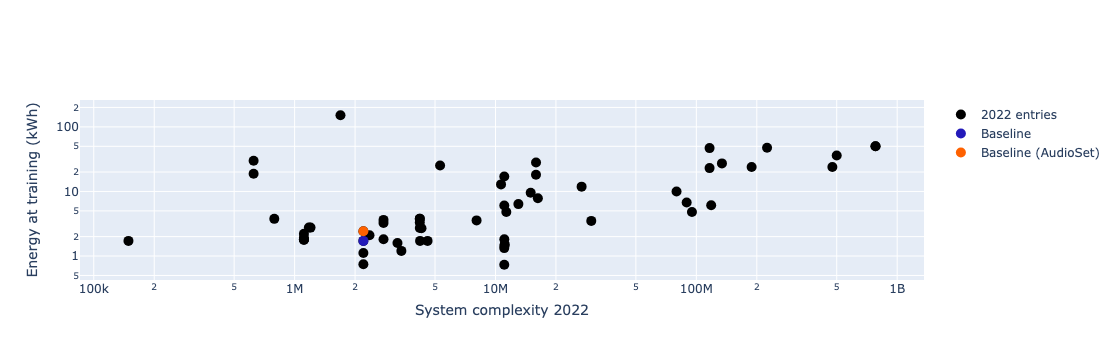

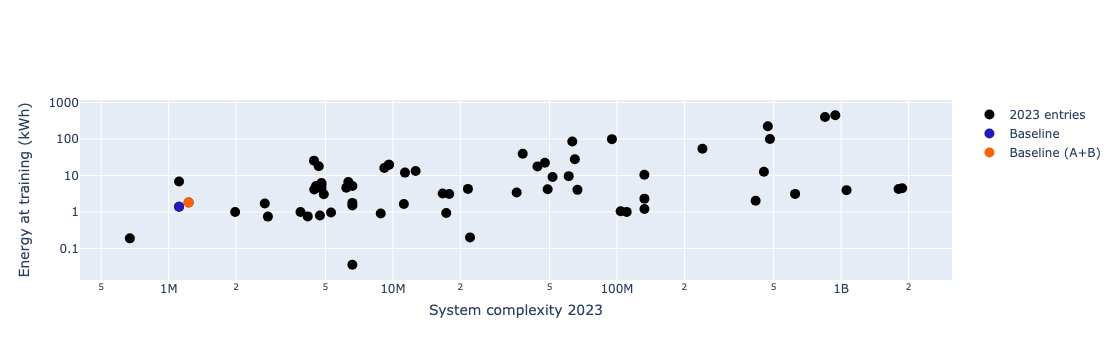

In [44]:
# Set the scale type for the x and y axes
type_xaxes = 'log'
type_yaxes = 'log'

# Specify the columns to consider from the dataframes
df_x = 'system_complexity'
df_y = 'energy_training'
text='code'

for df, year in zip([df_22, df_23], [2022, 2023]):
    x_axes_lab = f'System complexity {year}'
    y_axes_lab = 'Energy at training (kWh)'
    fig = scatter_all(df, df_x, df_y, x_axes_lab, y_axes_lab, text, add_base=True, year=year, show=False)
    
    fig.update_layout(
    xaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
)
    fig.show()
    
    file_name = os.path.join(fig_dir, f'systemCompl-energyTrain_{year}.pdf')
    save_image(fig, file_name)

The plots show that the system complexity tends to increase during the years, as well as the energy consumed at training. From the plot is also possible to observe that there is not a straightforward relation between system complexity and energy consumption at training. In fact, there are several systems with complexity in terms of parameters higher than 100 M which energy impact is less compared to a system complexity of 1 M. It is not possible to make any conclusion in terms of the relation between system complexity and energy consumption. 

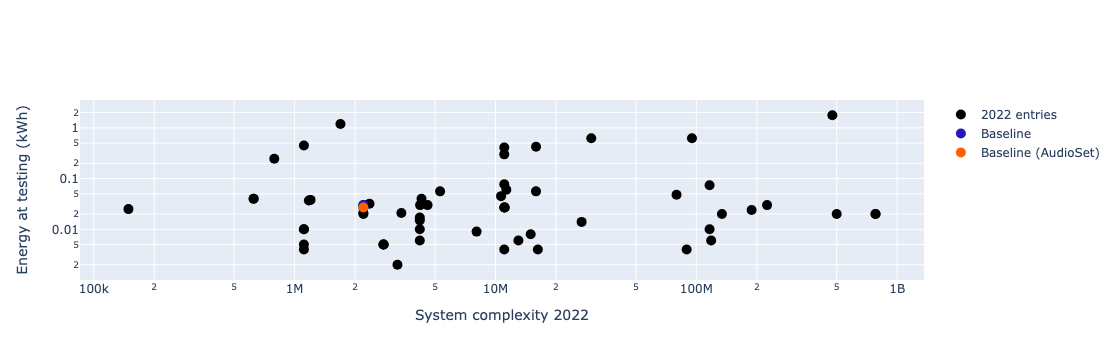

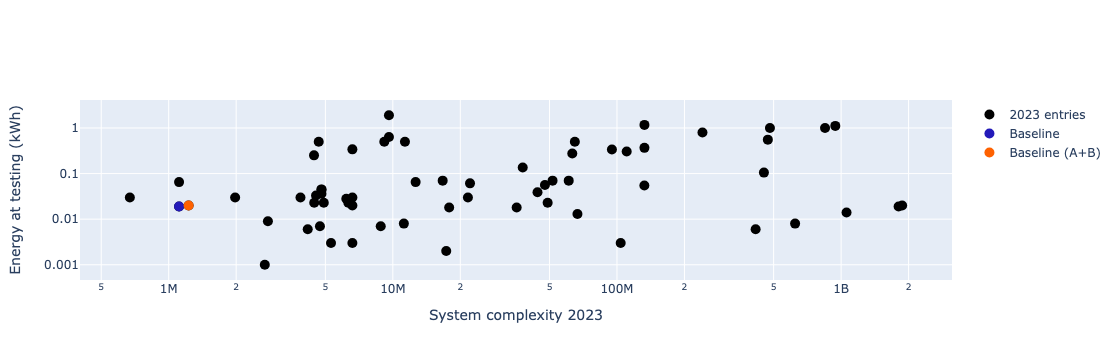

In [48]:
# Specify the columns to consider from the dataframes
df_y = 'energy_test'

for df, year in zip([df_22, df_23], [2022, 2023]):
    x_axes_lab = f'System complexity {year}'
    y_axes_lab = 'Energy at testing (kWh)'
    fig = scatter_all(df, df_x, df_y, x_axes_lab, y_axes_lab, text, add_base=True, year=year, show=False)
    
    fig.show()
    
    file_name = os.path.join(fig_dir, f'systemCompl-energyTest_{year}.pdf')
    save_image(fig, file_name)

The plots show that the energy consumed at testing stays more or less in the same range, even if there is a higher concentration of systems consuming between 0.1 and 2 kWH at testing.
Anyway, this plot confirms that it is not possible to make any conclusions in terms of the relation between system complexity and consumption. 

### General statistics for 2022 and 2023 systems

In [49]:
# print statistics for dataframe 
print_statistics([df_22, df_23], ['DCASE_22', 'DCASE_23'])

Statistics for DataFrame DCASE_22 in terms of the metric considered
       system_complexity energy_training energy_test
count             60.000          60.000      60.000
mean        66867695.167          12.960       0.121
std        164530606.436          22.642       0.297
min           148852.000           0.733       0.002
25%          2200000.000           1.815       0.010
median       6676303.000           3.699       0.026
75%         18903660.000          17.291       0.046
max        780237640.000         151.415       1.772


Statistics for DataFrame DCASE_23 in terms of the metric considered
       system_complexity energy_training energy_test
count             64.000          64.000      64.000
mean       167357893.125          28.109       0.211
std        379777002.250          79.355       0.366
min           671000.000           0.036       0.001
25%          4804956.000           1.617       0.019
median      14662273.000           4.295       0.035
75%         97

The values reported in the above tables confirm the previous comments. It is clear that the systems increase in terms of size, in terms of energy consumption at training and at testing.
Even if also mean and standard deviation are reported, due to the big variability of data, it makes more sense to analyze the results in terms of median, 25th percentile, and 75th percentile. 

Focusing on system complexity, we can observe that the 25th percentile for the DCASE 2023 submissions is more than double compared to the 25th percentile of the DCASE 2022 submissions. The same conclusions can be reached for the 75th percentile.

Different conclusions could be driven by the energy at training and testing, but those values are not normalized so they are not really objective evaluations and we cannot really consider them to draw a conclusion on the trend in the last two years for this particular metric.

## RELATION BETWEEN SYSTEM COMPLEXITY, MACS, AND ENERGY CONSUMPTION

In 2023, the energy consumption metric became mandatory to submit, together with the number of Multiply-Accumulate Operations (MACs). This decision has been taken in order to have more objective metrics for a fair comparison between systems. 
We asked participants to normalize the energy to the baseline. 

For the rest of the script, we are considering only the energy normalized. Moreover, the rest of the script is focused only on the DCASE 2023 submissions. In this way, we guarantee fairness and objectivity throughout the analysis. 

In [50]:
# Define a list of column names that we are interested in from the DataFrame.
columns_name = ['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params', 'system_ensemble_method_subsystem_count', 'code']

# Define a subset of columns that we want to consider for analysis.
subset = ['system_complexity_params', 'energy_training_normalized', 'energy_test_normalized']

# Create a new DataFrame 'df_only_23' by selecting only the columns specified in 'columns_name' from 'df_all_23'.
df_only_23 = df_all_23[columns_name]

# Remove duplicate rows from 'df_only_23' based on the columns specified in 'subset'.
df_only_23.drop_duplicates(subset=subset, inplace=True)

# Reset the index of 'df_only_23' after dropping duplicates and discard the previous index.
df_only_23.reset_index(inplace=True, drop=True)

# Optionally, print the resulting DataFrame 'df_only_23'.
# Uncomment the line below to print the DataFrame.
# print_df(df_only_23)


### Relation between system complexity and energy at training

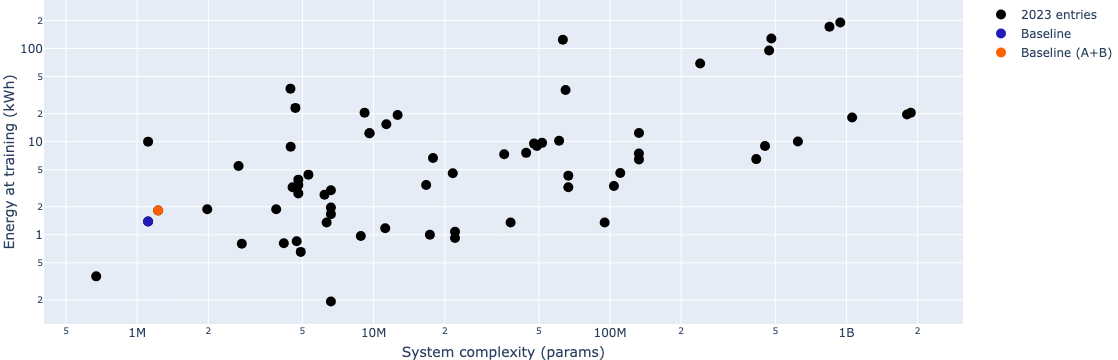

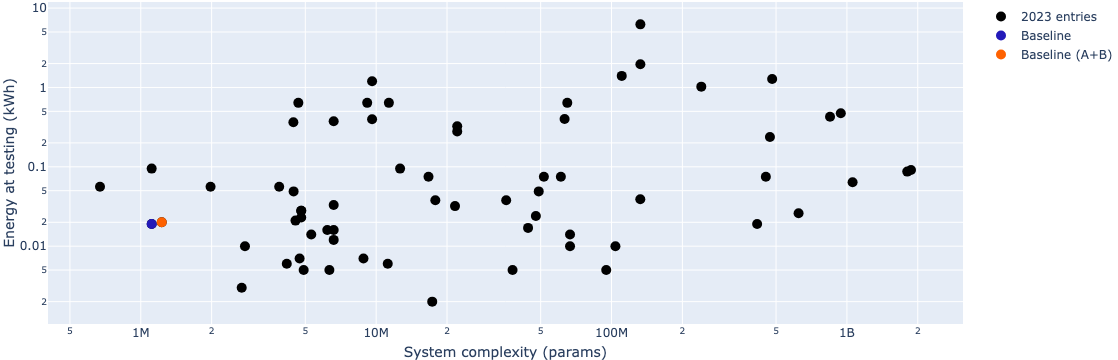

In [60]:
# Define the variables for the scatter plot.
x = 'system_complexity_params'       # X-axis data column

# Define labels for the x and y axes.
x_axes_lab = 'System complexity (params)'

# Column containing code or labels to be displayed on the plot.
code = 'code'

for y_label, phase in zip(['training', 'test'], ["training", "testing"]):
    y = f'energy_{y_label}_normalized'     # Y-axis data column
    y_axes_lab = f'Energy at {phase} (kWh)'

    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df_only_23, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'sc-energy-{phase}.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)
    

Also when the energy normalized is considered, the plots show that the system complexity does not relate in a straightforward way to the energy consumed at training.
In fact, there are systems with a complexity of 5 M parameters that consume more energy than systems with a complexity of 1 B parameters. This indicates that it is not possible to consider the system complexity as a solid metric to predict the energy consumption of SED systems.


Anyway, the distribution between the energy consumed is more or less the same so if we know how much a system is consuming at training, it is possible to predict how much it will consume at testing. Anyway, in general, the system complexity metric does not have a linear and positive relation with the energy consumed at training or testing. 

### Relation between MACs and energy at training

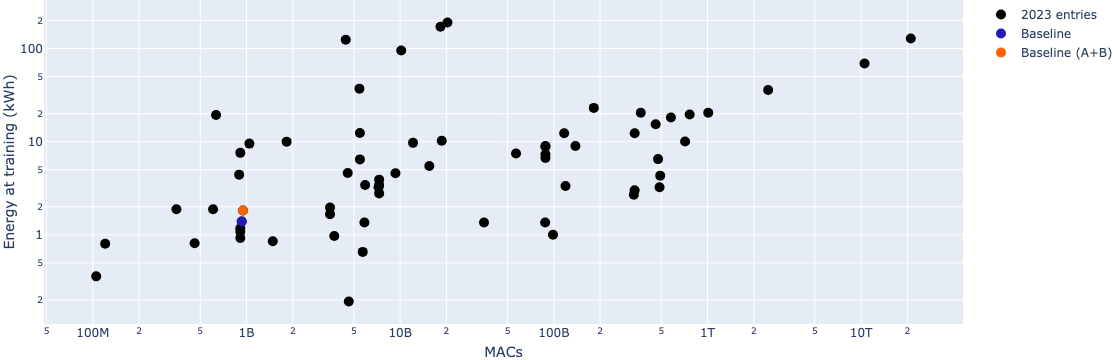

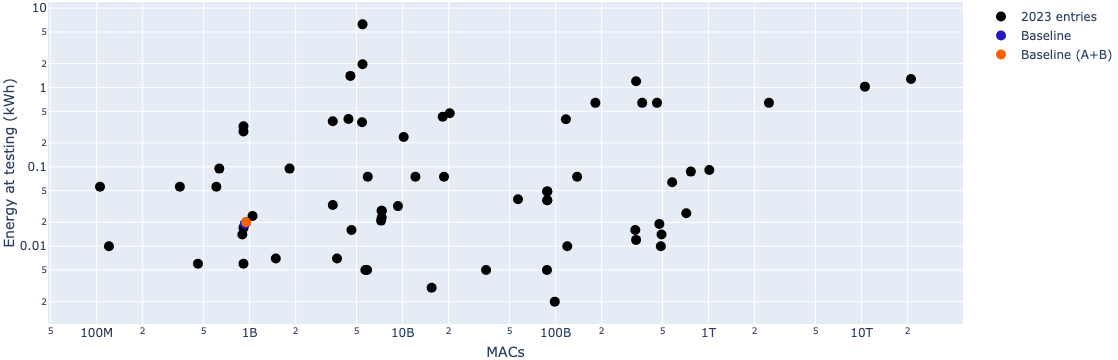

In [61]:
# Define the variables for the scatter plot.
x = 'macs'       # X-axis data column

# Define labels for the x and y axes.
x_axes_lab = 'MACs'

# Column containing code or labels to be displayed on the plot.
code = 'code'

for y_label, phase in zip(['training', 'test'], ["training", "testing"]):
    y = f'energy_{y_label}_normalized'     # Y-axis data column
    y_axes_lab = f'Energy at {phase} (kWh)'

    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df_only_23, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'sc-energy-{phase}.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)
    

From the plots, it is possible to observe that MACs correlate slightly more with energy at training than system complexity. It is surprising that MACs correlate better with training energy than test energy, while the other way around would be expected as MACs are computed at test time. This difference might be related to different system architectures but this would have to be verified in extensive experiments.

## RELATION BETWEEN PERFORMANCE AND ENERGY CONSUMPTION

In [69]:
# Define a list of selected columns from the DataFrame
selected_columns = ['energy_training_normalized', 'energy_test_normalized', 'psds1_eval_full', 'psds2_eval_full', 'macs', 'code', 'system_ensemble_method_subsystem_count']

# Create a subset of the selected columns excluding the last one
subset = selected_columns[:-1]

# Create a new DataFrame 'df_focus_23' by selecting only the specified columns and dropping rows with missing values in the subset
df_focus_23 = df_all_23[selected_columns]
df_focus_23.dropna(subset=subset, inplace=True)

# Define the number of decimal places for rounding
decimal_places = 2

# Round specific columns in 'df_focus_23' to the specified number of decimal places
df_focus_23["psds1_eval_full"] = df_focus_23["psds1_eval_full"].apply(round_to, args=(decimal_places, ))
df_focus_23["psds2_eval_full"] = df_focus_23["psds2_eval_full"].apply(round_to, args=(decimal_places, ))

# Remove duplicate rows in 'df_focus_23' and reset the index
df_focus_23.drop_duplicates(inplace=True)
df_focus_23.reset_index(inplace=True, drop=True)

# Create a new DataFrame 'df_focus_23_ne' containing only rows where 'system_ensemble_method_subsystem_count' is NaN
df_focus_23_ne = df_focus_23[df_focus_23['system_ensemble_method_subsystem_count'].isna()]

# Create a new DataFrame 'df_focus_23_e' containing only rows where 'system_ensemble_method_subsystem_count' is not NaN
df_focus_23_e = df_focus_23[df_focus_23['system_ensemble_method_subsystem_count'].notna()]

# Print the number of entries in different subsets of the DataFrame
print(f"We got a total of {len(df_focus_23)} entries submissions (after the processing). ")
print(f"We got a total of {len(df_focus_23_ne)} no-ensemble entries submissions. ")
print(f"We got a total of {len(df_focus_23_e)} ensemble entries submissions. ")

We got a total of 86 entries submissions (after the processing). 
We got a total of 39 no-ensemble entries submissions. 
We got a total of 47 ensemble entries submissions. 


In [70]:
# Sort the 'df_focus_23' DataFrame by 'psds1_eval_full' column in descending order to consider the best-performing systems
df_focus_23 = df_focus_23.sort_values(by='psds1_eval_full', ascending=False)

# Select the top 25 systems based on the 'psds1_eval_full' metric
df_focus_23_top = df_focus_23[:25]

# Select the bottom 15 systems based on the 'psds1_eval_full' metric
df_focus_23_bottom = df_focus_23[-25:]

# Reset the index of the top and bottom DataFrames for consistency
df_focus_23_top.reset_index(inplace=True, drop=True)
df_focus_23_bottom.reset_index(inplace=True, drop=True)

In [71]:
# Create a DataFrame 'df_baseline_1' containing rows with 'code' equal to 'Baseline_task4a_1'
df_baseline_1 = df_focus_23[df_focus_23['code'] == 'Baseline_task4a_1']

# Create a DataFrame 'df_baseline_2' containing rows with 'code' equal to 'Baseline_task4a_2'
df_baseline_2 = df_focus_23[df_focus_23['code'] == 'Baseline_task4a_2']

In [72]:
# Remove any trailing numbers in the 'code' column using regular expression replacement - top systems
df_focus_23_top['code'] = df_focus_23_top['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_top' based on selected columns and select the top 15 unique rows
df_top = df_focus_23_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top = pd.concat([df_top, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top' DataFrame for consistency
df_top.reset_index(inplace=True, drop=True)

In [73]:
# Remove any trailing numbers in the 'code' column using regular expression replacement - bottom systems
df_focus_23_bottom['code'] = df_focus_23_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_top' based on selected columns and select the bottom 15 unique rows
df_bot = df_focus_23_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_top' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot = pd.concat([df_bot, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top' DataFrame for consistency
df_bot.reset_index(inplace=True, drop=True)

#### Relation between **PSDS_1 and energy**, both at training and testing, for top systems. 

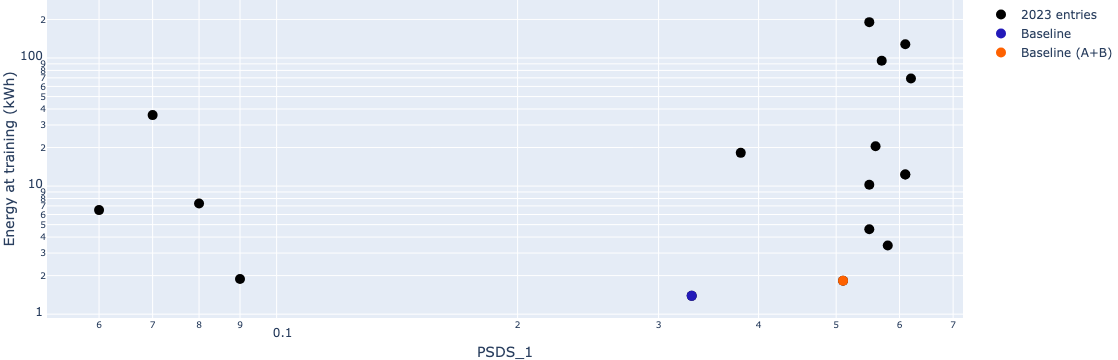

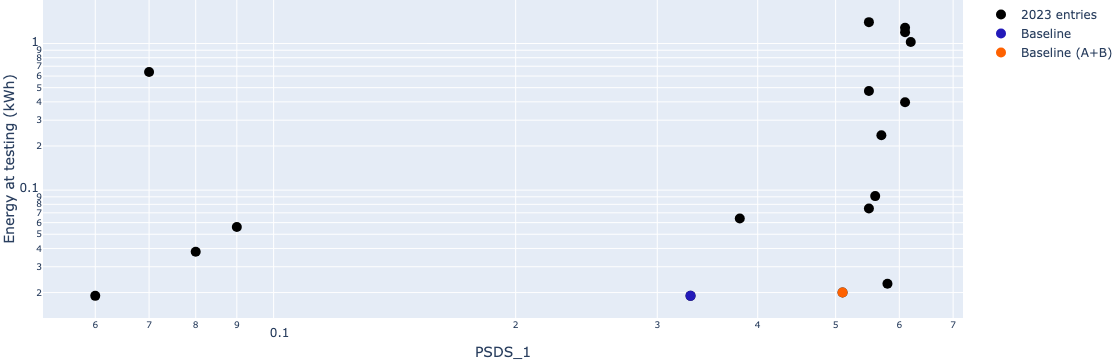

In [93]:
# Define the variables for the scatter plot
x = 'psds1_eval_full'
x_axes_lab = 'PSDS_1'

for y_label, phase in zip(['training', 'test'], ["training", "testing"]):
    y = f'energy_{y_label}_normalized'     # Y-axis data column
    y_axes_lab = f'Energy at {phase} (kWh)'

    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'psds1-energy-{phase}-top.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)

#### Relation between **PSDS_1 and energy**, both at training and testing, for lowest ranked systems. 

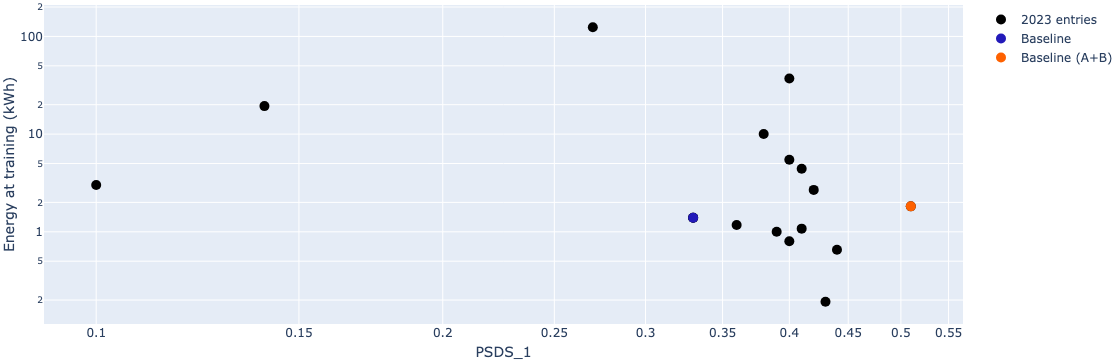

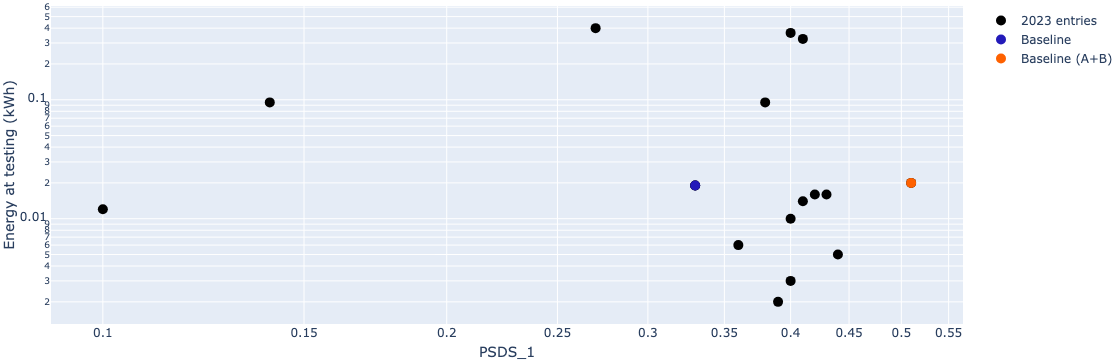

In [94]:
# Define the variables for the scatter plot
x = 'psds1_eval_full'
x_axes_lab = 'PSDS_1'

for y_label, phase in zip(['training', 'test'], ["training", "testing"]):
    y = f'energy_{y_label}_normalized'     # Y-axis data column
    y_axes_lab = f'Energy at {phase} (kWh)'

    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df_bot, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'psds1-energy-{phase}-low.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)

The figures highlight the diversity in terms of system efficiency. For PSDS_1, some systems manage to outperform the baseline results while consuming less energy. It should be noted that the top-performing systems are not the systems that consume the most energy. The same observation holds true for energy consumption during the test phase. 

It can also be observed that energy consumed for training and testing has a similar distribution. 

The same conclusions can be made for the lowest ranked systems.

#### Relation between **PSDS_2 and energy**, both at training and testing, for top systems. 

In [80]:
# Sort the 'df_focus_23' DataFrame by 'psds2_eval_full' column in descending order to consider the best-performing systems
df_focus_23 = df_focus_23.sort_values(by='psds2_eval_full', ascending=False)

# Select the top 25 systems based on the 'psds2_eval_full' metric
df_focus_23_top = df_focus_23[:25]

# Select the bottom 25 systems based on the 'psds2_eval_full' metric
df_focus_23_bottom = df_focus_23[-25:]

# Reset the index of the top and bottom DataFrames for consistency
df_focus_23_top.reset_index(inplace=True, drop=True)
df_focus_23_bottom.reset_index(inplace=True, drop=True)


In [81]:
# Remove any trailing numbers in the 'code' column using regular expression replacement for the top systems
df_focus_23_top['code'] = df_focus_23_top['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_top' based on selected columns and select the top 15 unique rows
df_top = df_focus_23_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top = pd.concat([df_top, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top' DataFrame for consistency
df_top.reset_index(inplace=True, drop=True)

In [82]:
# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom systems
df_focus_23_bottom['code'] = df_focus_23_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_bottom' based on selected columns and select the bottom 15 unique rows
df_bot = df_focus_23_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot = pd.concat([df_bot, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot' DataFrame for consistency
df_bot.reset_index(inplace=True, drop=True)

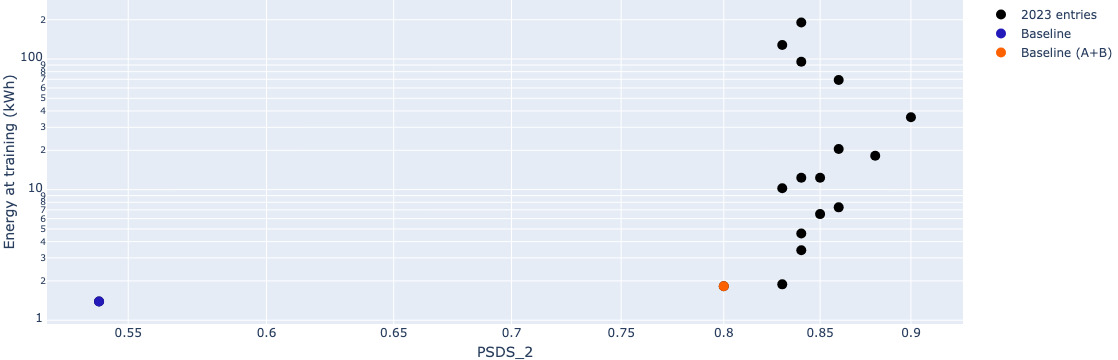

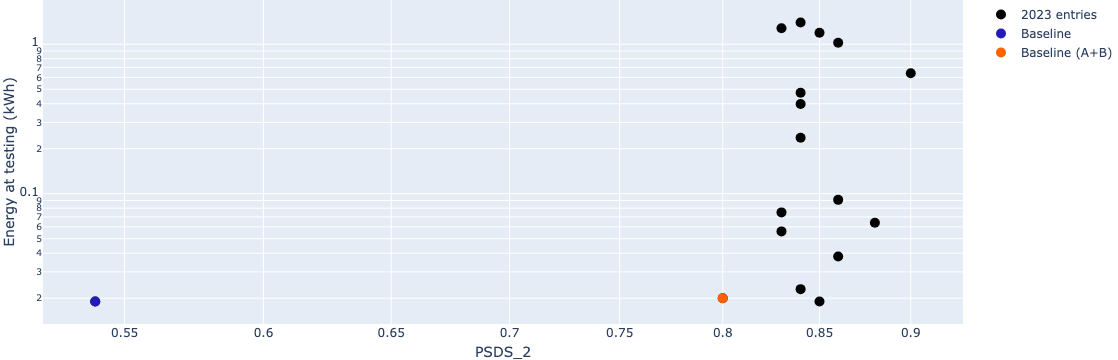

In [95]:
# Define the variables for the scatter plot
x = 'psds2_eval_full'
x_axes_lab = 'PSDS_2'

for y_label, phase in zip(['training', 'test'], ["training", "testing"]):
    y = f'energy_{y_label}_normalized'     # Y-axis data column
    y_axes_lab = f'Energy at {phase} (kWh)'

    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df_top, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'psds2-energy-{phase}-top.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)

#### Relation between **PSDS_2 and energy**, both at training and testing, for lowest ranked systems. 

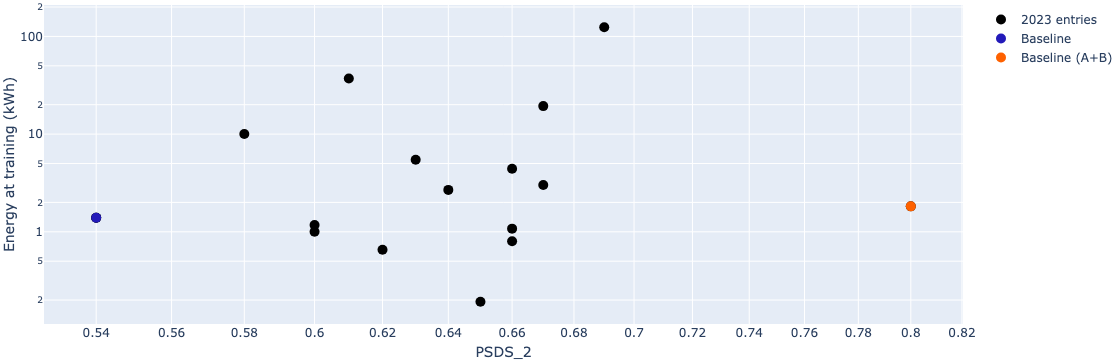

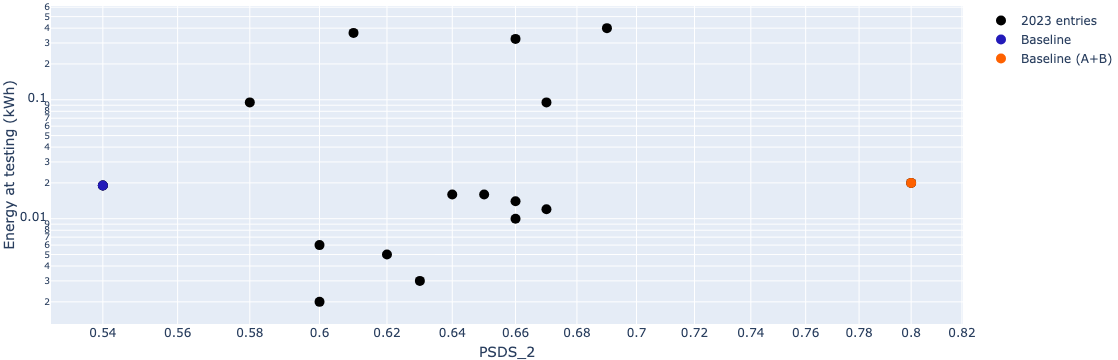

In [96]:
# Define the variables for the scatter plot
x = 'psds2_eval_full'
x_axes_lab = 'PSDS_2'

for y_label, phase in zip(['training', 'test'], ["training", "testing"]):
    y = f'energy_{y_label}_normalized'     # Y-axis data column
    y_axes_lab = f'Energy at {phase} (kWh)'

    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df_bot, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'psds2-energy-{phase}-low.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)

On the contrary of PSDS_1, for PSDS_2 none of the best performant systems was able to overcome the baseline performance consuming less energy than the baseline. 

#### ANALYSIS OF ENSEMBLE/NON-ENSEMBLE SYSTEMS

Considering **PSDS_1** and **highest** ranked systems

In [89]:
# For ensemble systems: Select the top 25 systems based on 'psds1_eval_full'
# and the bottom 25 systems based on the same metric
df_focus_23_e = df_focus_23_e.sort_values(by='psds1_eval_full', ascending=False)
df_focus_23_e_top = df_focus_23_e[:25]
df_focus_23_e_bottom = df_focus_23_e[-25:]

# For no-ensemble systems: Select the top 25 systems based on 'psds1_eval_full'
# and the bottom 25 systems based on the same metric
df_focus_23_ne = df_focus_23_ne.sort_values(by='psds1_eval_full', ascending=False)
df_focus_23_ne_top = df_focus_23_ne[:25]
df_focus_23_ne_bottom = df_focus_23_ne[-25:]


In [90]:
# Remove any trailing numbers in the 'code' column using regular expression replacement for the top ensemble systems
df_focus_23_e_top['code'] = df_focus_23_e_top['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the top no-ensemble systems
df_focus_23_ne_top['code'] = df_focus_23_ne_top['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom ensemble systems
df_focus_23_e_bottom['code'] = df_focus_23_e_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom no-ensemble systems
df_focus_23_ne_bottom['code'] = df_focus_23_ne_bottom['code'].str.replace(r'(_\d+)$', '')


In [91]:
# Remove duplicate rows in 'df_focus_23_e_top' based on selected columns and select the top 15 unique rows
df_top_e = df_focus_23_e_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top_e' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top_e = pd.concat([df_top_e, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top_e' DataFrame for consistency
df_top_e.reset_index(inplace=True, drop=True)


# Remove duplicate rows in 'df_focus_23_e_top' based on selected columns and select the bottom 15 unique rows
df_bot_e = df_focus_23_e_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot_e' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot_e = pd.concat([df_bot_e, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot_e' DataFrame for consistency
df_bot_e.reset_index(inplace=True, drop=True)

# Return the resulting 'df_top_e' DataFrame - optional
#df_top_e

In [92]:
# Remove duplicate rows in 'df_focus_23_ne_top' based on selected columns and select the top 15 unique rows
df_top_ne = df_focus_23_ne_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top_ne' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top_ne = pd.concat([df_top_ne, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top_ne' DataFrame for consistency
df_top_ne.reset_index(inplace=True, drop=True)


# Remove duplicate rows in 'df_focus_23_ne_bottom' based on selected columns and select the bottom 15 unique rows
df_bot_ne = df_focus_23_ne_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot_ne' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot_ne = pd.concat([df_bot_ne, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot_ne' DataFrame for consistency
df_bot_ne.reset_index(inplace=True, drop=True)

# Return the resulting 'df_top_ne' DataFrame - optional
#df_top_ne


Considering ensemble systems


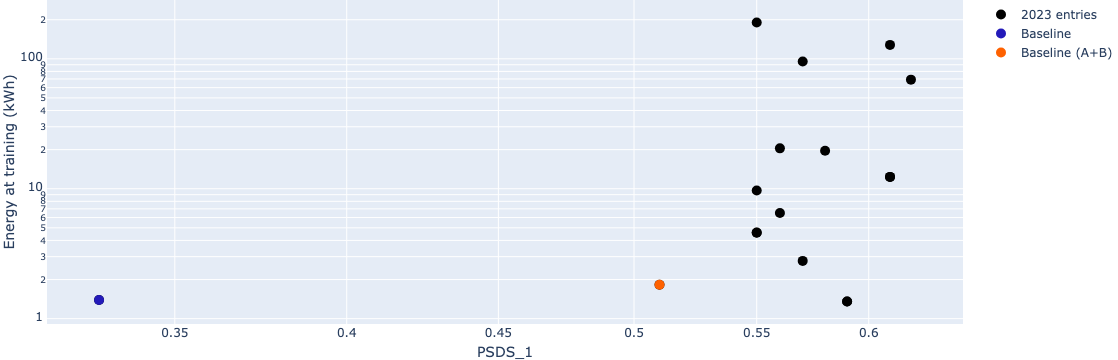

Considering no-ensemble systems


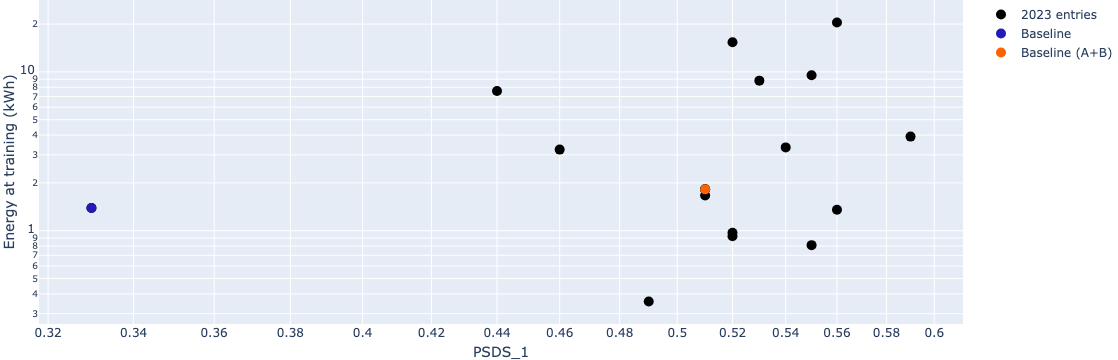

In [97]:
# Define the variables for the scatter plot
x = 'psds1_eval_full' 
y = 'energy_training_normalized'
x_axes_lab = 'PSDS_1'
y_axes_lab = 'Energy at training (kWh)'

for ens, df in zip(["ensemble", "no-ensemble"], [df_top_e, df_top_ne]):

    print(f"Considering {ens} systems")
    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'psds1-energy-{ens}-top.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)

Considering **PSDS_1** and **lowest** ranked systems

Considering ensemble systems


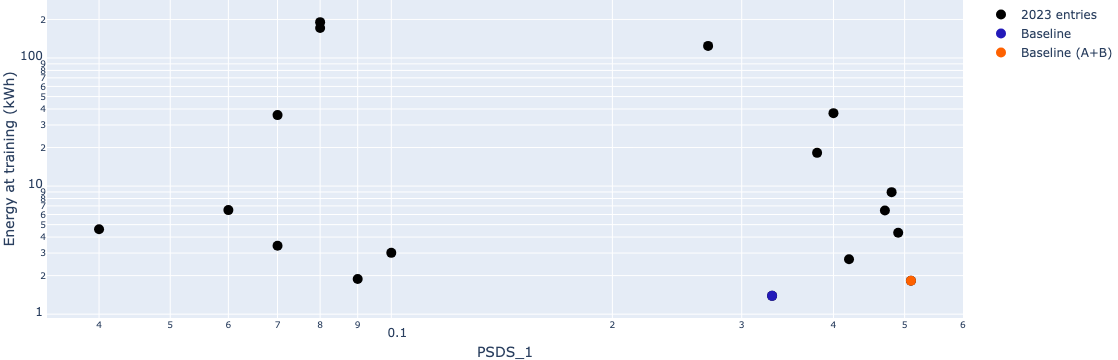

Considering no-ensemble systems


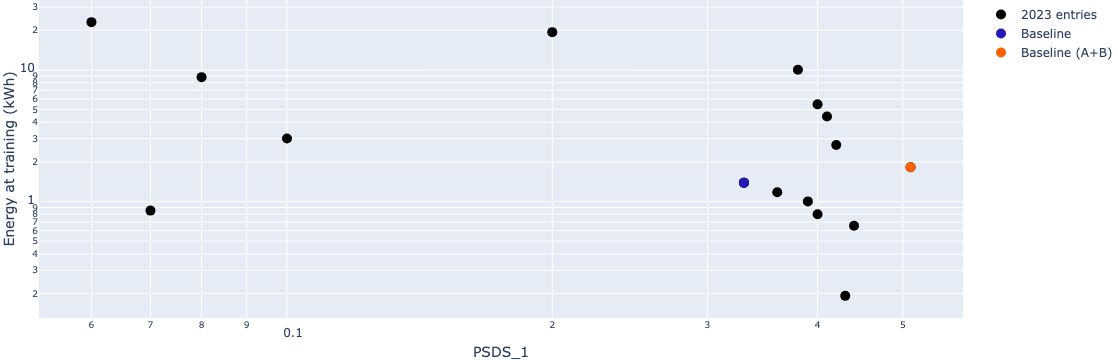

In [98]:
# Define the variables for the scatter plot
x = 'psds1_eval_full' 
y = 'energy_training_normalized'
x_axes_lab = 'PSDS_1'
y_axes_lab = 'Energy at training (kWh)'

for ens, df in zip(["ensemble", "no-ensemble"], [df_bot_e, df_bot_ne]):

    print(f"Considering {ens} systems")
    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'psds1-energy-{ens}-low.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)

Considering **PSDS_2** and **highest** ranked systems

In [177]:
# For ensemble systems: Select the top 25 systems based on 'psds2_eval_full'
# and the bottom 25 systems based on the same metric
df_focus_23_e = df_focus_23_e.sort_values(by='psds2_eval_full', ascending=False)
df_focus_23_e_top = df_focus_23_e[:25]
df_focus_23_e_bottom = df_focus_23_e[-25:]

# For no-ensemble systems: Select the top 25 systems based on 'psds2_eval_full'
# and the bottom 25 systems based on the same metric
df_focus_23_ne = df_focus_23_ne.sort_values(by='psds2_eval_full', ascending=False)
df_focus_23_ne_top = df_focus_23_ne[:25]
df_focus_23_ne_bottom = df_focus_23_ne[-25:]


In [178]:
# Remove any trailing numbers in the 'code' column using regular expression replacement for the top ensemble systems
df_focus_23_e_top['code'] = df_focus_23_e_top['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the top no-ensemble systems
df_focus_23_ne_top['code'] = df_focus_23_ne_top['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom ensemble systems
df_focus_23_e_bottom['code'] = df_focus_23_e_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove any trailing numbers in the 'code' column using regular expression replacement for the bottom no-ensemble systems
df_focus_23_ne_bottom['code'] = df_focus_23_ne_bottom['code'].str.replace(r'(_\d+)$', '')

# Remove duplicate rows in 'df_focus_23_e_top' based on selected columns and select the top 15 unique rows
df_top_e = df_focus_23_e_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top_e' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top_e = pd.concat([df_top_e, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top_e' DataFrame for consistency
df_top_e.reset_index(inplace=True, drop=True)


# Remove duplicate rows in 'df_focus_23_e_top' based on selected columns and select the bottom 15 unique rows
df_bot_e = df_focus_23_e_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot_e' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot_e = pd.concat([df_bot_e, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot_e' DataFrame for consistency
df_bot_e.reset_index(inplace=True, drop=True)

# Return the resulting 'df_top_e' DataFrame - optional
#df_top_e

# Remove duplicate rows in 'df_focus_23_ne_top' based on selected columns and select the top 15 unique rows
df_top_ne = df_focus_23_ne_top.drop_duplicates(subset=['macs', 'code'])[:15]

# Concatenate 'df_top_ne' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_top_ne = pd.concat([df_top_ne, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_top_ne' DataFrame for consistency
df_top_ne.reset_index(inplace=True, drop=True)


# Remove duplicate rows in 'df_focus_23_ne_bottom' based on selected columns and select the bottom 15 unique rows
df_bot_ne = df_focus_23_ne_bottom.drop_duplicates(subset=['macs', 'code'])[-15:]

# Concatenate 'df_bot_ne' with DataFrames 'df_baseline_1' and 'df_baseline_2'
df_bot_ne = pd.concat([df_bot_ne, df_baseline_1, df_baseline_2])

# Reset the index of the resulting 'df_bot_ne' DataFrame for consistency
df_bot_ne.reset_index(inplace=True, drop=True)

# Return the resulting 'df_top_ne' DataFrame - optional
#df_top_ne


Considering ensemble systems


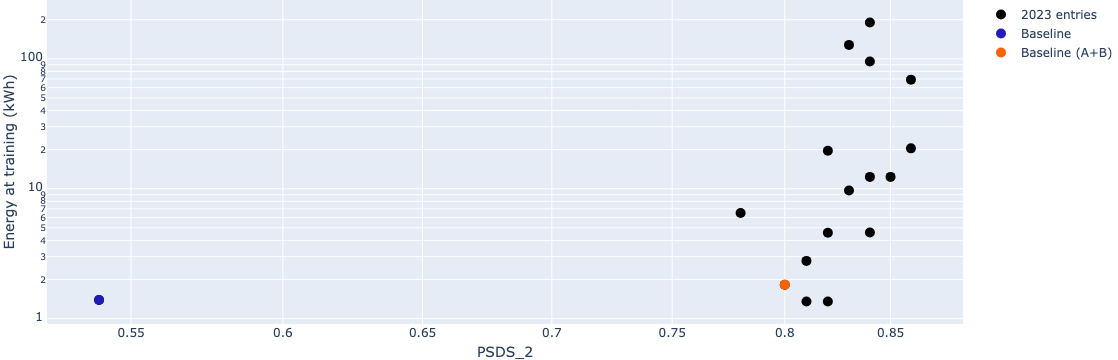

Considering no-ensemble systems


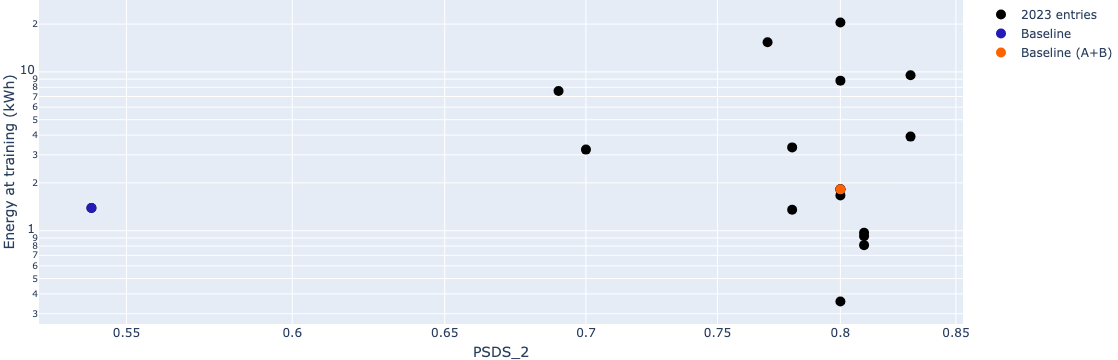

In [101]:
# Define the variables for the scatter plot
x = 'psds2_eval_full' 
y = 'energy_training_normalized'
x_axes_lab = 'PSDS_2'
y_axes_lab = 'Energy at training (kWh)'

for ens, df in zip(["ensemble", "no-ensemble"], [df_top_e, df_top_ne]):

    print(f"Considering {ens} systems")
    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize the legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'psds2-energy-{ens}-top.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)

Considering ensemble systems


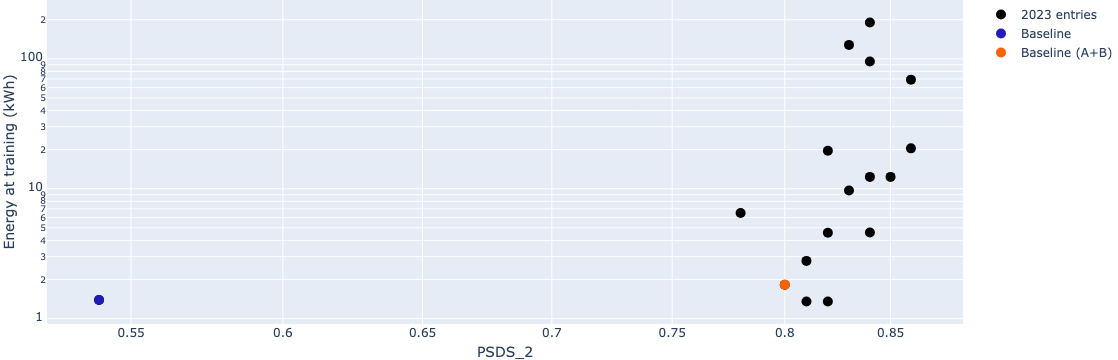

Considering no-ensemble systems


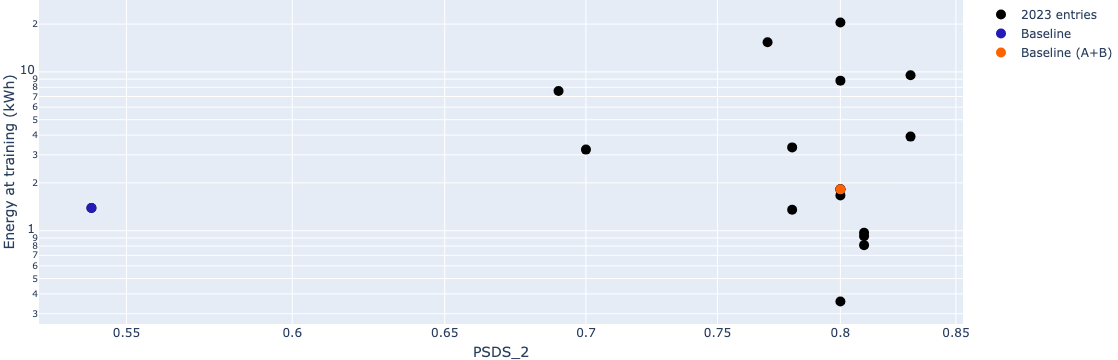

In [100]:
# Define the variables for the scatter plot
x = 'psds2_eval_full' 
y = 'energy_training_normalized'
x_axes_lab = 'PSDS_2'
y_axes_lab = 'Energy at training (kWh)'

for ens, df in zip(["ensemble", "no-ensemble"], [df_top_e, df_top_ne]):

    print(f"Considering {ens} systems")
    # Create a scatter plot using the 'scatter_all' function, but don't display it immediately (show=False).
    fig = scatter_all(df, x, y, x_axes_lab, y_axes_lab, code, add_base=True, year=2023, show=False)
    
    # Update the layout of the figure to customize the legend, axis titles, dimensions, and margins.
    fig.update_layout(
        xaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        yaxis=dict(
            title_standoff=10,          # Remove spacing between label and axis
        ),
        margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    )
    
    # Display the figure.
    fig.show()
    
    # Specify the directory for saving the figure and the file name.
    file_name = os.path.join(fig_dir, f'psds2-energy-{ens}-low.pdf')
    
    # Save the figure to the specified file with a defined format and scaling.
    save_image(fig, file_name)

From this analysis is possible to conclude that an ensemble is useful at combining systems that alone are not so good in achieving decent performance (this is not so efficient in terms of energy but these not-so-good systems are already expensive) while a single system can provide a lighter alternative to reach good performance anyway. In fact, the best not-ensemble system is able to achieve a PSDS_1 score of 0.58, while the best ensemble system scores 0.62 for PSDS_1.

It is interesting to note that in both cases there were systems able to overcome the baseline performances by consuming less energy than the baseline. 

## CONSIDERING THE WEIGHTED ENERGY

In [102]:
# Define a subset of columns to keep in the 'df_ew_23' DataFrame
subset_columns = ['ew_psds1_eval_full_train', 'ew_psds2_eval_full_train', 'ew_psds1_eval_full_test', 'ew_psds2_eval_full_test', 'psds1_eval_full', 'psds2_eval_full', 'code', 
                 'system_classifier', 'macs', 'system_complexity_time', 'system_data_augmentation', 'system_features', 'pre_trained_models', 'system_ensemble_method_subsystem_count']

# Create 'df_ew_23' DataFrame by selecting specific columns from 'df_all_23'
df_ew_23 = df_all_23[subset_columns]

# Drop duplicates based on selected columns
df_ew_23.drop_duplicates(subset=['ew_psds1_eval_full_train', 'ew_psds1_eval_full_test', 'macs', 'code'], inplace=True)

# Filter out data related to baseline systems for further processing
baseline_1 = df_ew_23[df_ew_23['code'] == 'Baseline_task4a_1']
baseline_2 = df_ew_23[df_ew_23['code'] == 'Baseline_task4a_2']

# Drop rows with code 'Baseline_task4'
df_ew_23.drop(df_ew_23[df_ew_23['code'] == 'Baseline_task4'].index, inplace=True)

# Concatenate 'df_ew_23' with baseline DataFrames
df_ew_23 = pd.concat([df_ew_23, baseline_1, baseline_2])

# Remove any remaining duplicate rows
df_ew_23.drop_duplicates(inplace=True)

# Reset the index of the resulting 'df_ew_23' DataFrame for consistency
df_ew_23.reset_index(inplace=True, drop=True)

# Display the resulting 'df_ew_23' DataFrame - optional
#df_ew_23
df = df_ew_23[['psds1_eval_full', 'ew_psds1_eval_full_train', 'code']]

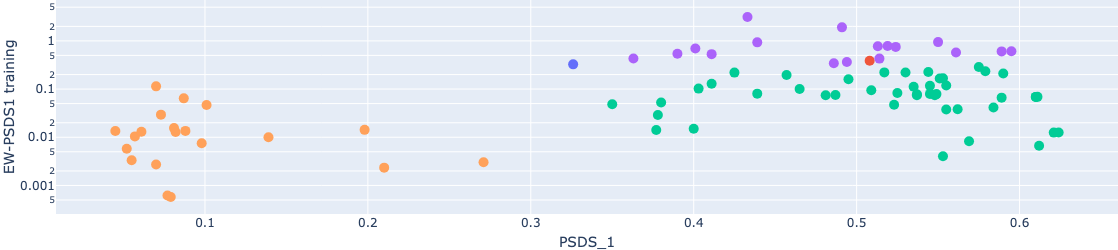

In [103]:
# Filter rows based on your conditions
baseline_row = df[df['code'] == 'Baseline_task4a_1']
baseline_psds1_eval_full = baseline_row['psds1_eval_full'].iloc[0]
baseline_ew_psds1_eval_full_train = baseline_row['ew_psds1_eval_full_train'].iloc[0]

# Create a new column for colors based on conditions
df['color'] = 'gray'  # Default color (gray)

df.loc[(df['psds1_eval_full'] > baseline_psds1_eval_full) & (df['ew_psds1_eval_full_train'] > baseline_ew_psds1_eval_full_train), 'color'] = 'blue'
df.loc[(df['psds1_eval_full'] > baseline_psds1_eval_full) & (df['ew_psds1_eval_full_train'] < baseline_ew_psds1_eval_full_train), 'color'] = 'yellow'
df.loc[(df['psds1_eval_full'] < baseline_psds1_eval_full) & (df['ew_psds1_eval_full_train'] > baseline_ew_psds1_eval_full_train), 'color'] = 'green'
df.loc[(df['psds1_eval_full'] < baseline_psds1_eval_full) & (df['ew_psds1_eval_full_train'] < baseline_ew_psds1_eval_full_train), 'color'] = 'pink'

df.loc[(df['code']=='Baseline_task4a_2'), 'color'] = 'black'
# Create a scatter plot using Plotly Express
fig = px.scatter(df, x='psds1_eval_full', y='ew_psds1_eval_full_train', color='color')  # Rename the legend label)

# Update plot labels and title
fig.update_layout(
    xaxis_title='psds1_eval_full',
    yaxis_title='ew_psds1_eval_full_train',
)

fig.update_traces(marker=dict(size=10))

fig.update_layout(
    xaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    yaxis=dict(
        title_standoff=10,          # Remove spacing between label and axis
    ),
    width=500,                    # Adjust the width as needed
    height=250,                  # Adjust the height as needed
    
    margin=dict(l=0, r=0, t=0, b=0.5),  # Set margins for the plot
    
    showlegend=False
)

fig.update_traces(name='Baseline', selector=dict(name='gray'))
fig.update_traces(name='Baseline (A+B)', selector=dict(name='black'))
fig.update_traces(name='energy < energy_base', selector=dict(name='blue'))
fig.update_traces(name='energy > energy_base', selector=dict(name='yellow'))
fig.update_traces(name='energy > energy_base', selector=dict(name='pink'))

# Update x-axis and y-axis labels
fig.update_xaxes(title_text='PSDS_1')
fig.update_yaxes(title_text='EW-PSDS1 training', type='log')

# Show the plot
fig.show()

save_image(fig, 'ew_psds1.pdf')

We can image the plot above divided into four areas: bottom left corner, showing the system that were outperformed by the baseline and still had potentially higher consumption; bottom right corner: systems that outperform the baseline but consume more energy; top right: systems that outperform the baseline with limited energy con- sumption increase. The area to which we should aim is the **top-right** corner, which includes a system able to right high performance, not underestimating the environmental impact they are going to have. Unfortunately, as the figure shows, they are still minorities. This Figure highlights how most of the systems required a higher quantity of energy at training compared to the baseline. Some systems of the top right and the bottom right have pretty close PSDS_1 while having pretty different energy consumption. 

## THRESHOLDING ANALYSIS

In [194]:
# Define a list of column names that we care about
columns_name = ['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params', 'system_ensemble_method_subsystem_count', 'code', 'psds1_eval_full', 'psds2_eval_full']

# Define a subset of column names that we want to keep
subset = ['system_complexity_params', 'energy_training_normalized', 'energy_test_normalized']

# Create a new DataFrame 'df_th' containing only the columns specified in 'columns_name'
df_th = df_all_23[columns_name]

# Remove duplicate rows in 'df_th' based on the values in the 'subset' columns
df_th.drop_duplicates(subset=subset, inplace=True)

# Reset the index of 'df_th' after removing duplicates and drop the old index
df_th.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_th'
# print_df(df_th)


In [195]:
# Create a new DataFrame 'df_23_not_ensembled' containing rows where 'system_ensemble_method_subsystem_count' is NaN (not ensembled)
df_23_not_ensembled = df_th[df_th.system_ensemble_method_subsystem_count.isna()]

# Create a new DataFrame 'df_23_ensembled' containing rows where 'system_ensemble_method_subsystem_count' is not NaN (ensembled)
df_23_ensembled = df_th[~df_th.system_ensemble_method_subsystem_count.isna()]

# Print the number of ensembled and not ensembled systems
print(f"Number of ensembled systems: {len(df_23_ensembled)}")
print(f"Number of not ensembled systems: {len(df_23_not_ensembled)}")


Number of ensembled systems: 34
Number of not ensembled systems: 32


In [196]:
quartile = 0.75

In [197]:
# Define the metric of interest
metric = 'energy_training_normalized'

# Calculate the median value for 'energy_training_normalized' in the ensembled systems
median_energy_training_normalized = df_23_ensembled[metric].quantile(quartile)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df_23_ensembled[df_23_ensembled[metric] > median_energy_training_normalized]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df_23_ensembled[df_23_ensembled[metric] < median_energy_training_normalized]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at training normalized is: {median_energy_training_normalized:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under threshold")

# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

The median for energy at training normalized is: 20.25
We have: 
	 - 9 above the threshold 
	 - 25 under threshold


,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
61,335800000000,12.334,1.195,9609912,46,Kim_GIST-HanwhaVision_task4a_5,0.61,0.846


In [198]:
# Define the metric of interest
metric = 'energy_test_normalized'

# Calculate the median value for 'energy_training_normalized' in the ensembled systems
median_energy_test_normalized = df_23_ensembled[metric].quantile(quartile)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df_23_ensembled[df_23_ensembled[metric] > median_energy_test_normalized]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df_23_ensembled[df_23_ensembled[metric] < median_energy_test_normalized]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at training normalized is: {median_energy_test_normalized:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under threshold")

# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

The median for energy at training normalized is: 0.42
We have: 
	 - 9 above the threshold 
	 - 25 under threshold


,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
62,116800000000,12.334,0.398,9609912,46,Kim_GIST-HanwhaVision_task4a_6,0.61,0.842


In [199]:
# Define the metric of interest
metric = 'macs'

# Calculate the median value for 'energy_training_normalized' in the ensembled system
median_MACs = df_23_ensembled[metric].quantile(quartile)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df_23_ensembled[df_23_ensembled[metric] > median_MACs]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df_23_ensembled[df_23_ensembled[metric] < median_MACs]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at training normalized is: {median_MACs:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under threshold")

# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

The median for energy at training normalized is: 484692750000.00
We have: 
	 - 9 above the threshold 
	 - 25 under threshold


,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
62,116800000000,12.334,0.398,9609912,46,Kim_GIST-HanwhaVision_task4a_6,0.61,0.842


In [200]:
# Define the metric of interest
metric = 'system_complexity_params'

# Calculate the median value for 'energy_training_normalized' in the ensembled systems
median_sc = df_23_ensembled[metric].quantile(quartile)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df_23_ensembled[df_23_ensembled[metric] > median_sc]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df_23_ensembled[df_23_ensembled[metric] < median_sc]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for system complexity params is: {median_sc:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under threshold")

# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

The median for system complexity params is: 443259000.00
We have: 
	 - 9 above the threshold 
	 - 25 under threshold


,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
48,10518000000000,69.12,1.024,240652180,25,Zhang_IOA_task4_1,0.621,0.858


In [201]:
# above threshold metrics for ensemble systems
df_above_threshold[['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params']].describe().applymap(custom_format)

,macs,energy_training_normalized,energy_test_normalized,system_complexity_params
count,9.00,9.00,9.00,9.00
mean,2.70e+12,73.62,0.31,950212040.00
std,6.89e+12,73.92,0.40,548420509.82
min,10160000000.00,8.97,0.03,452500000.00
25%,20320000000.00,18.17,0.07,481304360.00
50%,578115000000.00,20.46,0.09,847800000.00
75%,765529000000.00,128.00,0.43,1057200000.00
max,2.10e+13,190.55,1.28,1872000000.00


In [202]:
# Sort the 'df_under_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_under_threshold' after sorting and drop the old index
df_under_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_under_threshold'
# df_under_threshold

# Calculate summary statistics for specific columns of the 'df_under_threshold' DataFrame
# and apply a custom formatting function (assumed to be named 'custom_format')
df_under_threshold[['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params']].describe().applymap(custom_format)

# The 'describe' method computes statistics like count, mean, std, min, 25%, 50%, 75%, and max
# for the specified columns and formats the results using 'custom_format'.

# Uncomment the following line to print the summary statistics for the specified columns
# print(summary_stats)


,macs,energy_training_normalized,energy_test_normalized,system_complexity_params
count,25.00,25.00,25.00,25.00
mean,617236800000.00,15.85,0.57,73855024.40
std,2.12e+12,27.15,1.29,90841766.07
min,350000000.00,1.35,0.01,1979000.00
25%,5470000000.00,3.43,0.03,16687376.00
50%,35124000000.00,6.67,0.06,51596456.00
75%,116800000000.00,12.33,0.40,94940760.00
max,1.05e+13,124.32,6.24,415536000.00


In [203]:
# Sort the 'df_above_threshold' DataFrame by another metric 'psds1_eval_full' in descending order
df_above_threshold.sort_values(by='psds2_eval_full', ascending=False, inplace=True)

# Reset the index of 'df_above_threshold' after sorting and drop the old index
df_above_threshold.reset_index(inplace=True, drop=True)

# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
# df_above_threshold

**Not ensemble systems**

In [204]:
# Assign the DataFrame 'df_23_not_ensembled' to 'df'
df = df_23_not_ensembled

# Define the metric of interest
metric = 'energy_training_normalized'

# Calculate the median value for 'energy_training_normalized'
median_energy_training_normalized = df[metric].quantile(quartile)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df[df[metric] > median_energy_training_normalized]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df[df[metric] < median_energy_training_normalized]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at training normalized is: {median_energy_training_normalized:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under the threshold")
# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

The median for energy at training normalized is: 6.00
We have: 
	 - 8 above the threshold 
	 - 24 under the threshold


,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
28,7300000000,3.912,0.028,4804956,None,Kim_GIST-HanwhaVision_task4a_2,0.59,0.832


In [205]:
# Assign the DataFrame 'df_23_not_ensembled' to 'df'
df = df_23_not_ensembled

# Define the metric of interest
metric = 'energy_test_normalized'

# Calculate the median value for 'energy_training_normalized'
median_energy_test_normalized = df[metric].quantile(quartile)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df[df[metric] > median_energy_test_normalized]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df[df[metric] < median_energy_test_normalized]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for energy at testing normalized is: {median_energy_test_normalized:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under the threshold")
# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

The median for energy at testing normalized is: 0.07
We have: 
	 - 8 above the threshold 
	 - 24 under the threshold


,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
28,7300000000,3.912,0.028,4804956,None,Kim_GIST-HanwhaVision_task4a_2,0.59,0.832


In [206]:
# Assign the DataFrame 'df_23_not_ensembled' to 'df'
df = df_23_not_ensembled

# Define the metric of interest
metric = 'macs'

# Calculate the median value for 'energy_training_normalized'
median_macs = df[metric].quantile(quartile)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df[df[metric] > median_macs]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df[df[metric] < median_macs]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for MACs is: {median_macs:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under the threshold")
# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

The median for MACs is: 33660750000.00
We have: 
	 - 8 above the threshold 
	 - 24 under the threshold


,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
28,7300000000,3.912,0.028,4804956,None,Kim_GIST-HanwhaVision_task4a_2,0.59,0.832


In [207]:
# Assign the DataFrame 'df_23_not_ensembled' to 'df'
df = df_23_not_ensembled

# Define the metric of interest
metric = 'system_complexity_params'

# Calculate the median value for 'energy_training_normalized'
median_sc = df[metric].quantile(quartile)

# Filter and create a DataFrame 'df_above_threshold' containing systems with values above the median
df_above_threshold = df[df[metric] > median_sc]
df_above_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Filter and create a DataFrame 'df_under_threshold' containing systems with values below the median
df_under_threshold = df[df[metric] < median_sc]
df_under_threshold.sort_values(by=metric, ascending=False, inplace=True)

# Print the calculated median value for 'energy_training_normalized'
print(f"The median for MACs is: {median_sc:.2f}")

# Print the number of systems above and below the threshold
print(f"We have: \n\t - {len(df_above_threshold)} above the threshold \n\t - {len(df_under_threshold)} under the threshold")
# Uncomment the following line to print the resulting DataFrame 'df_above_threshold'
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold[:1]

The median for MACs is: 11231436.50
We have: 
	 - 8 above the threshold 
	 - 24 under the threshold


,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
28,7300000000,3.912,0.028,4804956,None,Kim_GIST-HanwhaVision_task4a_2,0.59,0.832


In [208]:
# above threshold for not ensembled systems
df_above_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_above_threshold.reset_index(inplace=True, drop=True)
df_above_threshold

,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
0,1045000000,9.527,0.024,47700000,None,Wenxin_TJU_task4a_5,0.537,0.817
1,119151000000,3.347,0.010,103884000,None,Li_USTC_task4a_5,0.530,0.762
2,460000000000,15.360,0.640,11325746,None,Zhang_IOA_task4_5,0.523,0.774
3,911717000,0.923,0.279,22100000,None,Liu_NSYSU_task4_7,0.519,0.814
4,911727000,7.582,0.017,44200000,None,Wenxin_TJU_task4a_7,0.439,0.687
5,911717000,1.077,0.325,22100000,None,Liu_NSYSU_task4_4,0.411,0.656
6,98754000000,1.002,0.002,17307000,None,Wu_NCUT_task4a_1,0.390,0.597
7,633627000,19.345,0.095,12637170,None,Barahona_AUDIAS_task4a_3,0.198,0.647


In [209]:
# above threshold metrics for not ensembled systems
df_above_threshold[['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params']].describe().applymap(custom_format)

,macs,energy_training_normalized,energy_test_normalized,system_complexity_params
count,8.00,8.00,8.00,8.00
mean,85289848500.00,7.27,0.17,35156739.50
std,159175749440.61,7.07,0.23,30931185.45
min,633627000.00,0.92,0.00,11325746.00
25%,911717000.00,1.06,0.02,16139542.50
50%,978363500.00,5.46,0.06,22100000.00
75%,103853250000.00,10.99,0.29,45075000.00
max,460000000000.00,19.34,0.64,103884000.00


In [210]:
# under threshold for not ensembled systems
df_under_threshold.sort_values(by='psds1_eval_full', ascending=False, inplace=True)
df_under_threshold.reset_index(inplace=True, drop=True)
df_under_threshold

,macs,energy_training_normalized,energy_test_normalized,system_complexity_params,system_ensemble_method_subsystem_count,code,psds1_eval_full,psds2_eval_full
0,7300000000,3.912,0.028,4804956,None,Kim_GIST-HanwhaVision_task4a_2,0.590,0.832
1,7300000000,3.432,0.023,4804956,None,Kim_GIST-HanwhaVision_task4a_3,0.579,0.836
2,368000000000,20.480,0.640,9160520,None,Zhang_IOA_task4_6,0.562,0.795
3,5854000000,1.354,0.005,6329384,None,Chen_CHT_task4_2,0.561,0.780
4,459620000,0.811,0.006,4171844,None,Xiao_FMSG_task4a_4,0.550,0.814
5,88200000000,8.806,0.049,4460124,None,Guan_HIT_task4a_3,0.525,0.800
6,3726000000,0.971,0.007,8832068,None,Xiao_FMSG_task4a_2,0.524,0.809
7,3497000000,1.666,0.033,6600000,None,Cheimariotis_DUTH_task4a_1,0.514,0.796
8,948793000,1.821,0.020,1227236,None,Baseline_task4a_2,0.508,0.798
9,105200000,0.358,0.056,671000,None,Wang_XiaoRice_task4a_1,0.491,0.802


In [211]:
# under threshold metrics for not ensembled systems
df_under_threshold[['macs', 'energy_training_normalized', 'energy_test_normalized', 'system_complexity_params']].describe().applymap(custom_format)

,macs,energy_training_normalized,energy_test_normalized,system_complexity_params
count,24.00,24.00,24.00,24.00
mean,57397274666.67,4.27,0.09,5004344.75
std,118051565708.02,5.94,0.19,2628900.68
min,105200000.00,0.19,0.00,671000.00
25%,944320250.00,0.94,0.01,3821604.00
50%,4179000000.00,1.89,0.02,4804956.00
75%,9345250000.00,4.04,0.04,6600000.00
max,368000000000.00,23.04,0.64,11200000.00
